### Sundqvist Scheme

How about we fit the Sundqvist model where we fit the tuning parameters to the data? <br>
We let the parameters depend on whether they are taken over land or over the sea.

In this version, we find the optimal set of hyperparameters automatically!

In [1]:
# 1000 samples, grid_spacing of 0.2: 12 seconds
# 1000 samples, grid_spacing of 0.1: 130 seconds

# 100.000 samples, grid_spacing of 0.2: 850 seconds
# 100.000 samples, grid_spacing of 0.1: Should take 2-3 hours

In [2]:
import os
import sys
import time
import json
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.model_selection import GridSearchCV
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.callbacks import LambdaCallback

sys.path.insert(0, '/home/b/b309170/workspace_icon-ml/symbolic_regression/')
from functions import evaluate_sundqvist

# Added to the PDF name
ran = np.random.randint(10**3)
print(ran)

seed = 7
np.random.seed(seed)

2022-04-16 10:45:54.757621: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


25


In [3]:
# Load columns of data
folder_data = '/home/b/b309170/my_work/icon-ml_data/cloud_cover_parameterization/grid_cell_based_v3/based_on_var_interpolated_data'

input_train = np.load(os.path.join(folder_data, 'cloud_cover_all_days_input_train_1.npy'))
input_valid = np.load(os.path.join(folder_data, 'cloud_cover_all_days_input_valid_1.npy'))
output_train = np.load(os.path.join(folder_data, 'cloud_cover_all_days_output_train_1.npy'))
output_valid = np.load(os.path.join(folder_data, 'cloud_cover_all_days_output_valid_1.npy'))

In [4]:
# Unscale the data
mean = [5.37518440e-03, 4.65389731e-07, 2.59635412e+02, 5.52329389e+04, 6.79260772e+03, 2.58097095e-01]
std = [6.01943993e-03, 3.95009930e-06, 3.55940285e+01, 3.26642242e+04, 6.20726361e+03, 4.28313535e-01]

input_train = input_train*std + mean
input_valid = input_valid*std + mean

In [5]:
# Load surface pressure
ps_train = np.load(os.path.join(folder_data, 'ps_unscaled_input_train_1.npy'))
ps_valid = np.load(os.path.join(folder_data, 'ps_unscaled_input_valid_1.npy'))

In [6]:
input_train = np.concatenate((input_train, np.expand_dims(ps_train, 1)), axis=1)
input_valid = np.concatenate((input_valid, np.expand_dims(ps_valid, 1)), axis=1)

In [8]:
# Features
new_features = ['qv', 'qi', 'temp', 'pres', 'zg', 'fr_land', 'ps']

# To locate variables
loc = {}
for i in range(len(new_features)):
    loc[new_features[i]] = i
    
input_train.shape

(26482169, 7)

In [9]:
# Add relative humidity
pres_train = input_train[:, loc['pres']]
qv = input_train[:, loc['qv']]
temp = input_train[:, loc['temp']]

T0 = 273.15
r = 0.00263*pres_train*qv*np.exp((17.67*(temp-T0))/(temp-29.65))**(-1)

new_features.append('rh')
input_train = np.append(input_train, np.expand_dims(r, -1), axis=1)

# The same for input_valid
pres_valid = input_valid[:, loc['pres']]
qv = input_valid[:, loc['qv']]
temp = input_valid[:, loc['temp']]

T0 = 273.15
r = 0.00263*pres_valid*qv*np.exp((17.67*(temp-T0))/(temp-29.65))**(-1)

input_valid = np.append(input_valid, np.expand_dims(r, -1), axis=1)

In [10]:
# Updating loc
loc = {}
for i in range(len(new_features)):
    loc[new_features[i]] = i
    
input_train.shape

(26482169, 8)

In [11]:
# We split the training data into cells over land vs sea
land_ind = np.where(input_train[:, loc['fr_land']] > 0.5)[0]
sea_ind = np.where(input_train[:, loc['fr_land']] <= 0.5)[0]

input_land = input_train[land_ind]
output_land = output_train[land_ind]
input_sea = input_train[sea_ind]
output_sea = output_train[sea_ind]

In [13]:
len(land_ind)/input_train.shape[0]

0.260109660957152

### Fitting hyperparameters
Original ones: $r_{sat} = 1, r_{0, top} = 0.8, r_{0, surf} = 0.968, n = 2$

### Create custom layer

In [14]:
class Sundq_Layer(tf.keras.layers.Layer):

    # These are the output units
    def __init__(self, units=1):
        super(Sundq_Layer, self).__init__()
        self.units = units

    def build(self, input_shape):  # Create the state of the layer (weights)
        
        # Initializing with the original values
        # rsat must always be greater than r0_top and r0_surf! How could we enforce this? (*)
        rsat_init = tf.constant_initializer(1)
        r0_top_init = tf.constant_initializer(0.8)
        r0_surf_init = tf.constant_initializer(0.968)
        n_init = tf.constant_initializer(2)  
    
        self.rsat = tf.Variable(name='rsat', initial_value=rsat_init(shape=(1, self.units), dtype='float32'), trainable=True)
        self.r0_top = tf.Variable(name='r0_top', initial_value=r0_top_init(shape=(1, self.units), dtype='float32'), trainable=True)
        self.r0_surf = tf.Variable(name='r0_surf', initial_value=r0_surf_init(shape=(1, self.units), dtype='float32'), trainable=True)
        self.n = tf.Variable(name='n', initial_value=n_init(shape=(1, self.units), dtype='float32'), trainable=True)

    def call(self, inputs):  # Defines the computation from inputs to outputs
        ps = inputs[:, 0]
        p = inputs[:, 1]
        rh = inputs[:, 2]
        
        r0 = self.r0_top + (self.r0_surf - self.r0_top)*tf.exp(1-(ps/p)**self.n)
        
        # div < 0, only if rsat < r0. But this goes against (*)
        div = (tf.minimum(rh, self.rsat) - self.rsat)/(r0 - self.rsat)
        
        # tf.sqrt is tricky, because its gradient in 0 is infinite!
        c = 1 - tf.sqrt(tf.maximum(div, 1e-9)) # in [0,1]
        
        # If rh > r0 we return c, otherwise we set it to 0
        c_out = tf.maximum(tf.sign(rh - r0), 0)*c
        
        return 100*tf.transpose(c)

**Land**

In [15]:
# Best parameters from the hyperparameter search
epochs_opt = 10
batchsize_opt = 32
optimizer_opt = tf.keras.optimizers.Adagrad
lr_opt = 0.0523026

In [16]:
sundq_layer = Sundq_Layer()
model = tf.keras.models.Sequential(sundq_layer)
model.compile(optimizer=optimizer_opt(learning_rate=lr_opt), loss='mse')

2022-04-16 10:51:10.681549: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-04-16 10:51:10.682286: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-04-16 10:51:10.682297: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2022-04-16 10:51:10.682320: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (l40148.atos.local): /proc/driver/nvidia/version does not exist
2022-04-16 10:51:10.683741: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild

In [17]:
import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)

print_weights = LambdaCallback(on_epoch_end=lambda batch, logs: print(model.layers[0].get_weights()))

history = model.fit(input_land[:, [loc['ps'], loc['pres'], loc['rh']]], output_land, epochs=epochs_opt, batch_size=batchsize_opt, \
                   callbacks = [print_weights])

2022-04-16 10:51:18.221779: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-04-16 10:51:18.237321: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2450085000 Hz


Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
215259/215259 [==============================] - 79s 365us/step - loss: 123.8615
[array([[2.422234]], dtype=float32), array([[0.00693164]], dtype=float32), array([[0.59241045]], dtype=float32), array([[0.91213924]], dtype=float32)]
Epoch 2/10
215259/215259 [==============================] - 76s 352us/step - loss: 108.0200
[array([[2.497706]], dtype=float32), array([[-0.00656802]], dtype=float32), array([[0.5860639]], dtype=float32), array([[0.9103264]], dtype=float32)]
Epoch 3/10
215259/215259 [==============================] - 74s 344us/step - loss: 107.9200
[array([[2.5178297]], dtype=float32), array([[-0.00787538]], dtype=float32), array([[0.5867613]], dtype=float32), array([[0

In [18]:
model.weights

[<tf.Variable 'sundq__layer/rsat:0' shape=(1, 1) dtype=float32, numpy=array([[2.5241508]], dtype=float32)>,
 <tf.Variable 'sundq__layer/r0_top:0' shape=(1, 1) dtype=float32, numpy=array([[-0.0085735]], dtype=float32)>,
 <tf.Variable 'sundq__layer/r0_surf:0' shape=(1, 1) dtype=float32, numpy=array([[0.58564645]], dtype=float32)>,
 <tf.Variable 'sundq__layer/n:0' shape=(1, 1) dtype=float32, numpy=array([[0.91154075]], dtype=float32)>]

**Sea**

In [19]:
sundq_layer = Sundq_Layer()
model = tf.keras.models.Sequential(sundq_layer)
model.compile(optimizer=optimizer_opt(learning_rate=lr_opt), loss='mse')

In [20]:
print_weights = LambdaCallback(on_epoch_end=lambda batch, logs: print(model.layers[0].get_weights()))

history = model.fit(input_sea[:, [loc['ps'], loc['pres'], loc['rh']]], output_sea, epochs=epochs_opt, batch_size=batchsize_opt, \
                   callbacks = [print_weights])

Epoch 1/10
612310/612310 [==============================] - 222s 361us/step - loss: 73.2702
[array([[2.1460562]], dtype=float32), array([[0.161563]], dtype=float32), array([[0.71197987]], dtype=float32), array([[1.9643687]], dtype=float32)]
Epoch 2/10
612310/612310 [==============================] - 223s 364us/step - loss: 68.2994
[array([[2.1514924]], dtype=float32), array([[0.16027173]], dtype=float32), array([[0.7098121]], dtype=float32), array([[1.9705592]], dtype=float32)]
Epoch 3/10
612310/612310 [==============================] - 221s 361us/step - loss: 68.4589
[array([[2.1540356]], dtype=float32), array([[0.16258417]], dtype=float32), array([[0.71022373]], dtype=float32), array([[1.9732347]], dtype=float32)]
Epoch 4/10
612310/612310 [==============================] - 223s 364us/step - loss: 68.3171
[array([[2.1542845]], dtype=float32), array([[0.16122918]], dtype=float32), array([[0.7102008]], dtype=float32), array([[1.965485]], dtype=float32)]
Epoch 5/10
612310/612310 [=======

In [21]:
model.weights

[<tf.Variable 'sundq__layer_1/rsat:0' shape=(1, 1) dtype=float32, numpy=array([[2.1525826]], dtype=float32)>,
 <tf.Variable 'sundq__layer_1/r0_top:0' shape=(1, 1) dtype=float32, numpy=array([[0.16084777]], dtype=float32)>,
 <tf.Variable 'sundq__layer_1/r0_surf:0' shape=(1, 1) dtype=float32, numpy=array([[0.7102102]], dtype=float32)>,
 <tf.Variable 'sundq__layer_1/n:0' shape=(1, 1) dtype=float32, numpy=array([[1.968784]], dtype=float32)>]

### Performance with the best hyperparameter setting (To run)

Originally: $r_{sat} = 1, r_{0, top} = 0.8, r_{0, surf} = 0.968, n = 2$ <br> 
Manually tuned over land:
$r_{sat} = 1.12, r_{0, top} = 0.3, r_{0, surf} = 0.92, n = 0.8$ <br> 
Manually tuned over sea:
$r_{sat} = 1.07, r_{0, top} = 0.42, r_{0, surf} = 0.9, n = 1.1$ <br> 
Automatically tuned over land:
$r_{sat} = 2.52, r_{0, top} = 0, r_{0, surf} = 0.59, n = 0.91$ <br> 
Automatically tuned over sea:
$r_{sat} = 2.15, r_{0, top} = 0.16, r_{0, surf} = 0.71, n = 1.97$

In [13]:
# Differentiate between original, manually and automatically tuned!
mse_train, r2_train = evaluate_sundqvist(flattened_input_train, flattened_output_train, loc, tuned='automatically')
mse_train_land, r2_train_land = evaluate_sundqvist(input_land, output_land, loc, tuned='automatically')
mse_train_sea, r2_train_sea = evaluate_sundqvist(input_sea, output_sea, loc, tuned='automatically')
mse_valid, r2_valid = evaluate_sundqvist(flattened_input_valid, flattened_output_valid, loc, tuned='automatically')

In [14]:
# Write results to JSON

results = {}
results['Training MSE'] = mse_train
results['Training R2'] = r2_train
results['Land MSE'] = mse_train_land
results['Land R2'] = r2_train_land
results['Sea MSE'] = mse_train_sea
results['Sea R2'] = r2_train_sea
results['Validation MSE'] = mse_valid
results['Validation R2'] = r2_valid

with open('/home/b/b309170/workspace_icon-ml/symbolic_regression/baselines/sundqvist_results/results.json', 'w') as file:
    json.dump(results, file)

**Extra plot**

Text(0.5, 1.0, 'Cloud Cover distributions')

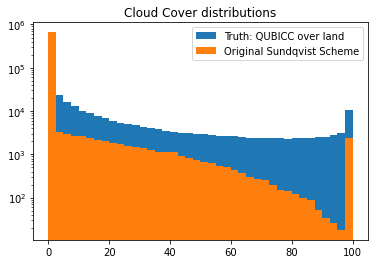

In [530]:
plt.hist(output_land, bins=40, log=True)
plt.hist(predictions, bins=40, log = True)
plt.legend(['Truth: QUBICC over land', 'Original Sundqvist Scheme'])
plt.title('Cloud Cover distributions')